In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import rioxarray

# run this file to define coord transformation functions
%run -i marconi_funcs.py

# Location of DEM
data_dir = 'F:/crs/proj/2025_Marconi_maps/Marconi_Products/'
fn = "2025-005-FA_Mar_Marconi_Topobathy_DSM_1m.tif"

# Define rotated local coordinate system
# Origin in UTM coords
e0=420080.0
n0=4638320.0
# Rotation (degrees, CCW from y-axis)
theta = 10

# make grids of both original (UTM) and rotated (local) coordinates
nx, ny, xu, yu, xrot, yrot, xcoords, ycoords = make_grid(name='marconi_local', e0=e0, n0=n0,
    xs=0., xend=200., ys=-100., yend=300., dxdy=1., theta=theta)

200 400
make_grid: Shape of xrot, yrot:  (400, 200) (400, 200)
corners x, corners y (orig. coords)
[[ 420097.77039755 4638222.09845266]
 [ 420293.7471404  4638256.65444002]
 [ 420224.46151751 4638649.59273347]
 [ 420028.48477467 4638615.03674612]
 [ 420097.77039755 4638222.09845266]]
Saving to marconi_local.csv


In [2]:
da = rioxarray.open_rasterio( data_dir+fn, masked=True )

print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
x = da['x'].values
y = np.flipud(da['y'].values)

# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
# However, make sure to squeeze before flipping
z = np.flipud(np.squeeze(da.values))
print(np.shape(x),np.shape(y),np.shape(z))

f = interpolate.RegularGridInterpolator( (y, x), z, method='linear')   

# Array for interpolated elevations
zi=np.nan * np.ones((ny,nx))
    
# this is the fast iteration, which only works when all of the source points fall inside the target box
try:
    zi=f((yu,xu))

# this is a slow iteration through all of the points, but allows us to skip ones that are outside
except:
    if(not iswarned):
        print("Warning: using slow iteration.")
        iswarned = True
    for ij in np.ndindex(zi.shape):
        try:
            zi[ij]=f((yu[ij],xu[ij]))
        except:
            zi[ij]=np.NaN

(1073,) (1298,) (1, 1073, 1298)
(1298,) (1073,) (1073, 1298)


8.080804574759679 4.860626855626341


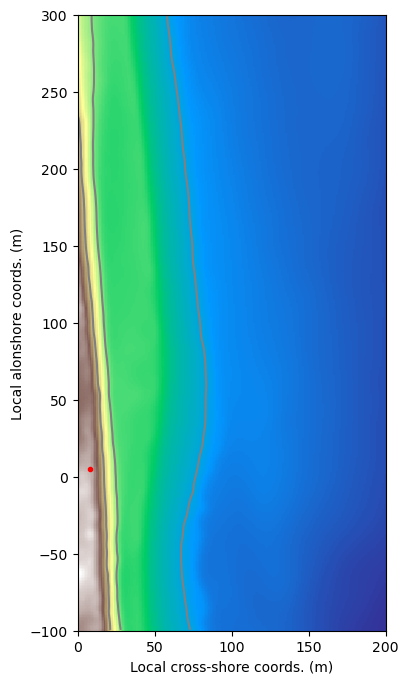

In [3]:
# Camera location in rotated coords
ce, cn = 420087.114, 4638326.19
cx, cy = UTM2local(ce, cn, eoff=e0, noff=n0, rot=10.0)
print(cx, cy)

# Contour elevations
levels = [-10 -5, 0, 5, 10 ]
fig, axes = plt.subplots(1, 1, figsize = (5, 8) )
plt.pcolormesh( xrot, yrot, zi, cmap='terrain' )
plt.contour( xrot, yrot, zi, levels=levels, colors='gray' )
plt.plot(cx, cy, '.r' )
plt.xlabel('Local cross-shore coords. (m)')
plt.ylabel('Local alonshore coords. (m)')
axes.set_aspect( 'equal' )

Text(0, 0.5, 'Elevaton (m NAVD88)')

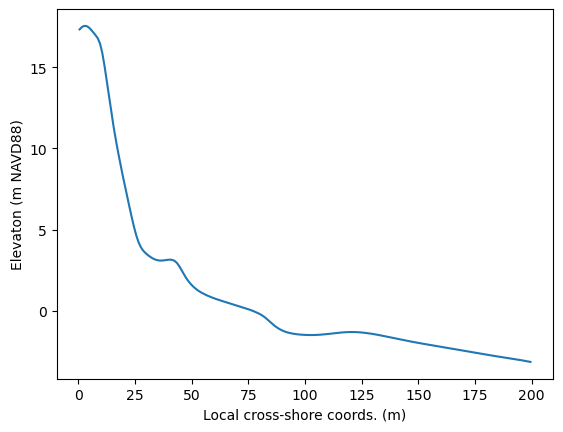

In [4]:
# plot a profile
# find yrot = ~0 (note cell centers are a 0.5 m)
y_index = int( np.argwhere( yrot[:,0]>=0. )[0][0] )
plt.plot( xrot[y_index,:], zi[y_index,:])
plt.xlabel('Local cross-shore coords. (m)')
plt.ylabel('Elevaton (m NAVD88)')